<a href="https://colab.research.google.com/github/art-glazunov/Non-standard-categorical-encodings/blob/main/LSA_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-standard categorical encodings
by Artyom Glazunov
#Part 1. Direct conversion to texts + topic modeling



### In this notebook, you can check out how topic modeling can help with categorical encoding and getting object embeddings in unsupervised manner. Such embeddings can be useful for solving many supervised and unsupervised learning tasks.

*In my experiments, I did not use specific random_states, so your results may differ from mine.*

In [ ]:
!pip install scikit-learn==0.24.1 --quiet

     |████████████████████████████████| 22.3MB 1.7MB/s 


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import gensim
import gensim.corpora as corpora

import sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.manifold import TSNE, MDS

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
sklearn.__version__

'0.24.1'

Download our train dataset from https://www.kaggle.com/c/cat-in-the-dat/data?select=train.csv into your directory, here I use a folder on my Google Drive to store the data. Of course, you can simply load the data into the folder on the left, without Google Drive. But if you want to mount your drive, you can do as instructed here https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166, *or just use a button on the left panel*). 

Change working dir

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/datafest/article

Check the folder

In [ ]:
!ls

LSA_encoding.ipynb  train.csv


Our file is here, let's load the data and split it into train and test parts

In [ ]:
data = pd.read_csv('train.csv', index_col = 'id')
train = data.iloc[:-70000]
print(train.shape)
train.head()

(230000, 24)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [ ]:
test = data.iloc[-70000:]
print(test.shape)
test.head()

(70000, 24)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
230000,1,1,0,F,Y,Green,Square,Dog,Russia,Piano,92190168b,fa498a5ae,d10553e7e,80be47228,47d38e9d3,1,Master,Lava Hot,e,U,MO,4,2,0
230001,0,0,0,T,Y,Red,Star,Lion,Canada,Piano,e7d9ca356,0b23e3352,40f84f6de,333f46907,e9e56a3f8,1,Expert,Boiling Hot,i,O,CM,1,1,0
230002,0,0,0,F,Y,Red,Circle,Cat,Canada,Bassoon,a3f640358,9b1c3c8b7,d1586e0e0,1b9339c49,973983691,3,Grandmaster,Freezing,b,T,RL,3,8,1
230003,1,0,0,T,N,Green,Trapezoid,Hamster,Costa Rica,Bassoon,0b3bec656,603232dea,5387ed7d2,da8be1022,508c9de37,1,Novice,Warm,e,U,Qo,2,11,0
230004,1,0,0,T,Y,Blue,Star,Axolotl,Canada,Piano,4173a0252,c135cdf77,91cd074b1,1a2fd4686,75193d88a,3,Novice,Hot,g,U,LE,4,12,1


Select only features

In [ ]:
categorical_cols = [col for col in train.columns if col != 'target']
print(categorical_cols)
len(categorical_cols)

['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']


23

So, get the data in a convenient format

In [ ]:
X_train = train[categorical_cols]
y_train = train['target']
X_test = test[categorical_cols]
y_test = test['target']

## BASE
Let's use ordinary encoding methods to get results for comparison.

LightGBM (out-of-the-box handler)

In [ ]:
%%time
def to_pd_categorical(data):
  """change the format of data to categorical"""
  X = data.copy()
  for col in X.columns:
    X[col] = pd.Categorical(X[col])
  return X

lgbm_clf = lgb.LGBMClassifier()
lgbm_clf.fit(to_pd_categorical(X_train), y_train)
probs = lgbm_clf.predict_proba(to_pd_categorical(X_test))
score_lgbm_default = roc_auc_score(y_test, probs[:,1])
print(score_lgbm_default)

0.783034361531605
CPU times: user 14.3 s, sys: 32.4 ms, total: 14.3 s
Wall time: 7.75 s


LightGBM (OHE)

In [ ]:
%%time
ohe = OneHotEncoder(handle_unknown='ignore')
lgbm_clf = lgb.LGBMClassifier()
lgbm_ohe_clf = Pipeline([
                          ('encoder', ohe),
                          ('classifier', lgbm_clf)
                        ])
lgbm_ohe_clf.fit(X_train, y_train)
probs = lgbm_ohe_clf.predict_proba(X_test)
score_lgbm_ohe = roc_auc_score(y_test, probs[:,1])
print(score_lgbm_ohe)

0.7566672479254364
CPU times: user 18.9 s, sys: 64.6 ms, total: 19 s
Wall time: 6.53 s


Logistic Regression (OHE)

In [ ]:
%%time
ohe = OneHotEncoder(handle_unknown='ignore')
model_lr = LogisticRegression()
lr_ohe_clf = Pipeline([
                        ('encoder', ohe),
                        ('classifier', model_lr)
                      ])
lr_ohe_clf.fit(X_train, y_train)
probs = lr_ohe_clf.predict_proba(X_test)
score_lr_ohe = roc_auc_score(y_test, probs[:,1])
print(score_lr_ohe)

0.8001741054831377
CPU times: user 12.3 s, sys: 31.2 s, total: 43.5 s
Wall time: 12.4 s


Let's look at the dimemsionality after OHE.

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
X_ohe = ohe.fit_transform(X_train)
X_ohe.shape

(230000, 16380)

Very big, isn't it?) We had two dozens of features and now we have more than 16 thousand! Embeddings will show that we can pack almost all of the original information into dimensionality of 700!

Logistic Regression (ordinal, scaled)

In [ ]:
%%time
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
model_lr = LogisticRegression()
lr_oe_clf = Pipeline([
                      ('encoder', ord_enc),
                      ('scaler', StandardScaler()),
                      ('classifier', model_lr)
                    ])
lr_oe_clf.fit(X_train, y_train)
probs = lr_oe_clf.predict_proba(X_test)
score_lr_oe = roc_auc_score(y_test, probs[:,1])
print(score_lr_oe)

0.7194894718221823
CPU times: user 2.29 s, sys: 963 ms, total: 3.25 s
Wall time: 2.03 s


## Embeddings

## Preprocessing

Let's create texts from our rows of data

In [ ]:
def categorical_to_texts(data):
  """Transform categorical data rows into texts as follows:
  “Var1Name_Value1 Var2Name_Value2 …”
  """
  new_data_list = []
  columns = list(data.columns)
  for line in tqdm(data.values):
    new_line = ''
    for pair in zip(columns, line):
      new_line = new_line + f'{pair[0]}_{pair[1]} '
    new_data_list.append(new_line)
  return new_data_list

In [ ]:
X_train_texts = categorical_to_texts(X_train)
X_test_texts = categorical_to_texts(X_test)
X_train_texts[1]

'bin_0_0 bin_1_1 bin_2_0 bin_3_T bin_4_Y nom_0_Green nom_1_Trapezoid nom_2_Hamster nom_3_Russia nom_4_Piano nom_5_b3b4d25d0 nom_6_fbcb50fc1 nom_7_3b6dd5612 nom_8_4cd920251 nom_9_f83c56c21 ord_0_1 ord_1_Grandmaster ord_2_Hot ord_3_a ord_4_A ord_5_bF day_7 month_8 '

To prepare the data for LSA we need to somehow vectorize it. Let's use CountVectorizer, consider unigrams and bigrams, and get rid of too rare and frequent tokens.

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=10,max_df=0.2)
bow_matrix = vectorizer.fit_transform(X_train_texts)
bow_matrix.shape

(230000, 28849)

Then make the data compatible with the gensim library.

In [ ]:
def vect2gensim(vectorizer, dtmatrix):
    """ transform sparse matrix into gensim corpus and dictionary """
    corpus_vect_gensim = gensim.matutils.Sparse2Corpus(dtmatrix, documents_columns=False)
    dictionary = gensim.corpora.dictionary.Dictionary.from_corpus(corpus_vect_gensim,
        id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))

    return (corpus_vect_gensim, dictionary)

In [ ]:
(gensim_corpus, gensim_dict) = vect2gensim(vectorizer, bow_matrix)

In [ ]:
bow_matrix_test = vectorizer.transform(X_test_texts)
gensim_corpus_test,_ = vect2gensim(vectorizer, bow_matrix_test)

Create a function to pull out the topic representations that will be our embeddings of objects.

In [ ]:
def get_topic_vectors(model,corpus):
  """Get new features form the topic LSA model and gensim corpus"""
  num_topics = len(model[corpus[1]])
  doc_vectors = np.zeros((len(corpus), num_topics))
  for i, doc in enumerate(tqdm(corpus)):
    topics = model[doc]
    for pair in topics:
      j = pair[0]
      doc_vectors[i,j] = pair[1]
  return doc_vectors

## Topic modeling

Get the embeddings and check the model performance and quality on LightGBM.

In [ ]:
%%time
lsamodel = gensim.models.LsiModel(gensim_corpus, num_topics=700, id2word = gensim_dict, power_iters=30)
lsa_features_train = get_topic_vectors(lsamodel, gensim_corpus)
lsa_features_test = get_topic_vectors(lsamodel, gensim_corpus_test)
lgbm_clf = lgb.LGBMClassifier()
lgbm_clf.fit(lsa_features_train, y_train)
probs = lgbm_clf.predict_proba(lsa_features_test)
score_lgbm_lsi = roc_auc_score(y_test, probs[:,1])
print(score_lgbm_lsi)


0.7507850556429279
CPU times: user 1h 36s, sys: 7min 57s, total: 1h 8min 34s
Wall time: 23min 49s


Let's look at feature importances

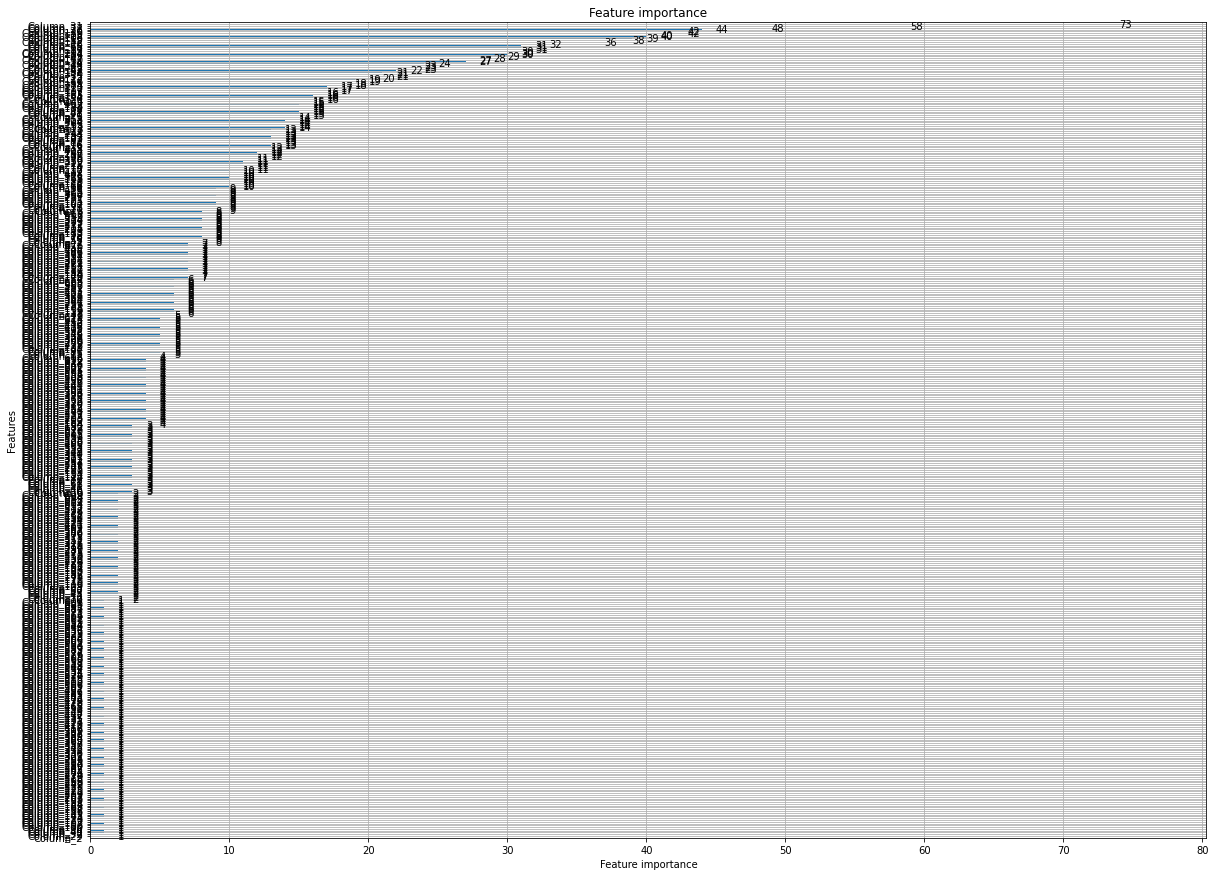

In [ ]:
lgb.plot_importance(lgbm_clf, importance_type='split', figsize=(20,15));

You can see that is this case we have unbalanced importance distribution, because of the fact that LSA is similar to PCA (first PC have more variance which correlates with info content). More complex methods (next article) will be slightly better in this problem.

Logistic Regression

In [ ]:
%%time
model_lr = LogisticRegression().fit(lsa_features_train, y_train)
probs = model_lr.predict_proba(lsa_features_test)
score_lr_lsi = roc_auc_score(y_test, probs[:,1])
print(score_lr_lsi)

0.7720975419867606
CPU times: user 54.6 s, sys: 8.8 s, total: 1min 3s
Wall time: 16.2 s


Let's check LSA training and encoding time

In [ ]:
%%time
lsamodel_ = gensim.models.LsiModel(gensim_corpus, num_topics=700, id2word = gensim_dict,power_iters=30)

CPU times: user 49min 8s, sys: 7min 3s, total: 56min 12s
Wall time: 18min 34s


In [ ]:
%%time
lsa_features_test_ = get_topic_vectors(lsamodel_, gensim_corpus_test)


CPU times: user 34.6 s, sys: 294 ms, total: 34.9 s
Wall time: 34.7 s


Conclusions:
- Simple (+)
- Long training and encoding time (-)
- Not bad in quality, we can preserve a lot of initial info in our embedding:) (+)
- Doesn't depend on the number of categorical features and their cardinality, that's nice) (+)
- Not very balanced info distibution among the components of our embeddings (-) 

# Visualization

Generate a subsample to visualize.

In [ ]:
_, emb_sample, _, _ = train_test_split(lsa_features_test, y_test, test_size=0.03)

Scale the data


In [ ]:
%%time
scaler = StandardScaler()
scaler.fit(lsa_features_train)

scaled_emb = scaler.transform(emb_sample)

CPU times: user 2.47 s, sys: 116 ms, total: 2.58 s
Wall time: 2.57 s


t-SNE

In [ ]:
%%time
tsne = TSNE(n_components=2, random_state=33)
T = tsne.fit_transform(scaled_emb)

CPU times: user 56.4 s, sys: 572 ms, total: 57 s
Wall time: 14.5 s


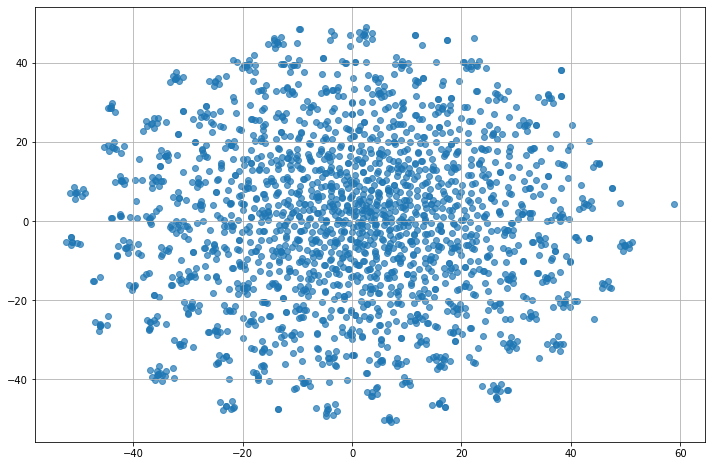

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(T[:,0], T[:,1], alpha=0.7)
plt.grid()

MDS

In [ ]:
%%time
mds_trans = MDS(n_components=2, random_state=33)
M = mds_trans.fit_transform(scaled_emb)

CPU times: user 3min 50s, sys: 6min 51s, total: 10min 42s
Wall time: 2min 42s


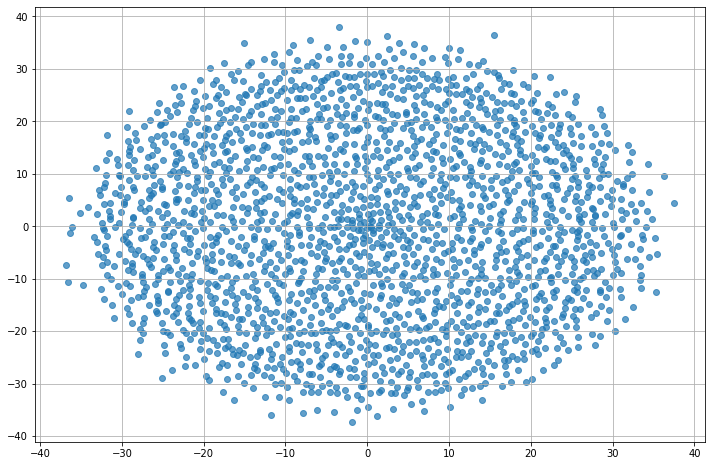

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(M[:,0], M[:,1], alpha=0.7)
plt.grid()

### Not very informative picture, is it? But this is only **the first part** of our journey, stay tuned :)

## Bonus experiment: another encoding variant

Let's encode our text data with TfidfVectorizer and then check the quality on MultinomialNB model.

In [ ]:
%%time
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.2)
X_train_tfidf = vectorizer.fit_transform(X_train_texts)
X_test_tfidf = vectorizer.transform(X_test_texts)

CPU times: user 16.4 s, sys: 146 ms, total: 16.5 s
Wall time: 16.5 s


In [ ]:
%%time
model_nb = MultinomialNB().fit(X_train_tfidf, y_train)
probs = model_nb.predict_proba(X_test_tfidf)
score_nb_tfidf = roc_auc_score(y_test, probs[:,1])
print(score_nb_tfidf)

0.7529499777533144
CPU times: user 126 ms, sys: 1.96 ms, total: 128 ms
Wall time: 127 ms


Let's compare with an ordinary approach

In [ ]:
%%time
nb_ohe_clf = Pipeline([
                        ('encoder', OneHotEncoder(handle_unknown='ignore')),
                        ('classifier', model_nb)
                      ])
nb_ohe_clf.fit(X_train, y_train)
probs = nb_ohe_clf.predict_proba(X_test)
score_nb_ohe = roc_auc_score(y_test, probs[:,1])
print(score_nb_ohe)

0.7838390923137883
CPU times: user 2.01 s, sys: 10.6 ms, total: 2.02 s
Wall time: 2.01 s


So, in this case OHE wins, but the very possibility of using tfidf of our texts as features is quite interesting, isn't it?:) Now, it looks like "truncated" OHE with document frequencies, but we could tune hyperparameters and see the results. Good luck)